<table>
    <tr>
        <td><img src="https://github.com/Alonso666cr/MachineLearning1/blob/main/urosario.jpg?raw=true" width="300"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="font-size:200%;color:blue;text-align:center">    <FONT COLOR="#359868">Proyecto Módulo 2   </p> Clasificación de textos </FONT>         </h1></td>         
        <td>
            <tp><p style="font-size:99%;text-align:center">Aplicaciones de Aprendizaje de Máquina</p></tp>
            <tp><p style="font-size:115%;text-align:center">Maestría MACC 2025-1</p></tp>
            <tp><p style="font-size:115%;text-align:center">Estudiantes: Nathaly Páez Ramos</p></tp>
            <tp><p style="font-size:115%;text-align:center">Andrés Cervantes Torres</p></tp>
            <tp><p style="font-size:115%;text-align:center">Miguel Betancourt Alonso</p></tp>
        </td>
    </tr>
</table>

### Importanción de librerías

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora
from gensim.models import LdaModel
import warnings
import nltk
nltk.download('punkt_tab')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Configuración general

A partir de los géneros válidos, se elige el que tiene mayor cantidad de registros. 

In [2]:
# Configuración global
TARGET_GENRE = 'Drama'
VALID_GENRES = [
    'Drama', 'Comedy', 'Documentary', 'Horror', 'Thriller', 
    'Western', 'Action', 'Animation', 'Science Fiction', 
    'Crime', 'Music', 'Adventure'
]
RANDOM_STATE = 42

### Carga de datos

Se utilizó el dataset público de Kaggle sobre películas, el cual posee aproximadamente 45000 registros. Se realiza la verificación de las columnas ['overview', 'genres'] y posteriormente se genera una advertencia si tenemos columnas vacías.

In [3]:
def load_movies_dataset():
    """
    Cargar el dataset de películas desde Kaggle
    """
    print("\n Paso #1: Cargando el dataset")
    print("-" * 40)
    
    try:
        import kagglehub
        from pathlib import Path
        
        # Download latest version
        path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")
        print("Path to dataset files:", path)
        
        file_name = Path(path, 'movies_metadata.csv')
        movies = pd.read_csv(file_name, low_memory=False)

        # Obtener la hora y fecha actual
        ahora = datetime.now()
        # Mostrar la hora actual en formato legible
        print("Inicio de operaciones:", ahora.strftime("%Y-%m-%d %H:%M:%S"))
        
        print(f" Dataset cargado exitosamente")
        print(f" Archivo: {file_name}")
        print(f" Forma del dataset: {movies.shape}")
        
        # Verificar columnas necesarias
        required_cols = ['overview', 'genres']
        missing_cols = [col for col in required_cols if col not in movies.columns]
        
        if missing_cols:
            print(f"  Advertencia: faltan columnas requeridas: {missing_cols}")
        else:
            print(" Todas las columnas requeridas están presentes")
            
        # Estadísticas básicas
        print(f"\n Estadísticas básicas:")
        print(f"  Total de películas: {len(movies):,}")
        print(f"  Sinopsis no vacías: {movies['overview'].notna().sum():,}")
        print(f"  Géneros no vacíos: {movies['genres'].notna().sum():,}")
        
        return movies
        
    except ImportError:
        print(" Error: kagglehub no está instalado")
        print("Instala con: pip install kagglehub")
        return None
    except Exception as e:
        print(f" Error cargando dataset: {e}")
        return None


### Preprocesamiento

<p style="text-align: justify;">En este proceso se presentan dos funciones clave para el procesamiento de texto en tareas de modelado de lenguaje. Primero, la función setup_nltk() se descarga de forma silenciosa los recursos esenciales de NLTK —como tokenizadores, lematizadores y listas de stopwords en inglés—, y se configura tres objetos fundamentales: un lematizador (WordNetLemmatizer), un conjunto de palabras vacías (stopwords) y un divisor de texto compatible con el modelo all-mpnet-base-v2, útil para el posterior fraccionamiento semántico de documentos en fragmentos de tamaño controlado. Segundo, preprocess_text() implementa un pipeline de limpieza y normalización textual: convierte el texto a minúsculas, elimina caracteres no alfabéticos, tokeniza las palabras, y filtra aquellas que son stopwords o tienen menos de tres caracteres, aplicando además lematización para reducir cada palabra a su forma base. De esta manera se mejora la calidad de las representaciones textuales en modelos como LDA.</p>


In [4]:
def setup_nltk():
    """
    Configurar recursos de NLTK
    """
    print("\n Paso #2: Configurando NLTK")
    print("-" * 40)
    
    try:
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True)
        print(" Recursos de NLTK descargados")
        
        # Configurar objetos globales
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        text_splitter = SentenceTransformersTokenTextSplitter(
            chunk_size=315,
            chunk_overlap=0,
            model_name="all-mpnet-base-v2"
        )
        
        return lemmatizer, stop_words, text_splitter
        
    except Exception as e:
        print(f" Error configurando NLTK: {e}")
        return None, None, None

def preprocess_text(text, lemmatizer, stop_words):
    """
    Preprocesamiento de texto para LDA
    """
    if pd.isna(text) or text == '':
        return []
    
    # Convertir a minúsculas y eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    
    # Tokenización
    tokens = word_tokenize(text)
    
    # Eliminar stopwords y lemmatizar
    tokens = [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token not in stop_words and len(token) > 2
    ]
    
    return tokens

### Filtrado estricto y codificación binaria del dataset para clasificación supervisada

<p style="text-align: justify;">Se realizan funciones que aseguran una depuración lógica y coherente del dataset antes del entrenamiento del modelo. Las funciones filter_dataset y prepare_target_variable implementan un filtrado riguroso y una codificación binaria de la variable objetivo para tareas de clasificación supervisada. En el caso de filter_dataset, depura el conjunto original eliminando registros con sinopsis vacías y seleccionando únicamente películas que posean exactamente un género perteneciente a una lista válida (VALID_GENRES), utilizando ast.literal_eval para interpretar correctamente el formato JSON embebido. Adicionalmente, se aplica una etapa extra de control de calidad textual donde se conserva solo las sinopsis que no requieren fragmentación semántica según el text_splitter, lo cual garantiza homogeneidad en longitud y estructura del texto de entrada. Además, prepare_target_variable convierte la columna categórica de género en una variable binaria que toma el valor 1 si la película corresponde al target_genre especificado, y 0 en caso contrario, generando así una estructura de clases adecuada para modelos de clasificación binaria.</p>

In [5]:
def filter_dataset(df, text_splitter, target_genre=TARGET_GENRE):
    """
    Filtrado del dataset según especificaciones
    """
    print(f"\n Paso #3: Filtrando dataset para '{target_genre}'")
    print("-" * 40)
    print(f"Dataset original: {len(df)} películas")
    
    # 1. Filtrar sinopsis vacías
    df = df.dropna(subset=['overview'])
    df = df[df['overview'].str.strip() != '']
    print(f" Después de eliminar sinopsis vacías: {len(df)} películas")
    
    # 2. Filtrar por géneros válidos (un solo género)
    df_filtered = []
    import ast
    
    for _, row in df.iterrows():
        if pd.isna(row['genres']) or row['genres'] == '':
            continue
        
        try:
            # Parsear JSON de géneros
            genres_list = ast.literal_eval(row['genres'])
            
            # Extraer nombres de géneros
            if isinstance(genres_list, list):
                genre_names = [genre['name'] for genre in genres_list if 'name' in genre]
            else:
                continue
            
            # Filtrar géneros válidos
            valid_movie_genres = [g for g in genre_names if g in VALID_GENRES]
            
            # Conservar solo películas con exactamente un género válido
            if len(valid_movie_genres) == 1:
                row_copy = row.copy()
                row_copy['genre'] = valid_movie_genres[0]
                df_filtered.append(row_copy)
                
        except (ValueError, SyntaxError, TypeError):
            continue
    
    df_filtered = pd.DataFrame(df_filtered)
    print(f" Después de filtrar por géneros válidos (1 género): {len(df_filtered)} películas")
    
    # 3. Fragmentación de sinopsis (conservar textos unificados)
    unified_texts = []
    for _, row in df_filtered.iterrows():
        try:
            chunks = text_splitter.split_text(row['overview'])
            if len(chunks) == 1:  # Solo textos que no se fragmentan
                unified_texts.append(row)
        except Exception:
            continue
    
    df_final = pd.DataFrame(unified_texts)
    print(f" Después de fragmentación (textos unificados): {len(df_final)} películas")
    
    # Mostrar distribución de géneros
    if len(df_final) > 0:
        print(f"\n Distribución de géneros:")
        genre_counts = df_final['genre'].value_counts()
        for genre, count in genre_counts.items():
            percentage = (count / len(df_final)) * 100
            print(f"  {genre}: {count} ({percentage:.1f}%)")
    else:
        print(" No se encontraron películas después del filtrado")
    
    return df_final

def prepare_target_variable(df, target_genre=TARGET_GENRE):
    """
    Preparar variable objetivo binaria
    """
    print(f"\n Paso #4: Preparando variable objetivo")
    print("-" * 40)
    
    df['target'] = (df['genre'] == target_genre).astype(int)
    
    print(f"Género objetivo: {target_genre}")
    print(f"Clase positiva (1 - {target_genre}): {df['target'].sum()} películas")
    print(f"Clase negativa (0 - Otros): {len(df) - df['target'].sum()} películas")
    print(f"Proporción {target_genre}: {df['target'].mean():.1%}")
    
    return df

### Preparación del corpus y diccionario LDA con filtrado de calidad textual



<p style="text-align: justify;">Uno de los insumos fundamentales para aplicar el modelado de temas con LDA es la función prepare_corpus, que garantiza una alinación estricta entre los documentos textuales y las correspodientes etiquetas. En primera instancia, cada sinopsis es preprocesada mediante lematización y eliminación de stopwords, descartando aquellas demasiado breves para evitar ruido semántico. Luego, se filtran los índices válidos, sincronizando así el DataFrame original con los textos procesados. Con esta base depurada, se genera un diccionario de palabras utilizando gensim.corpora.Dictionary, aplicando un umbral mínimo y máximo de frecuencia relativa para eliminar términos irrelevantes o dominantes. El resultado es un corpus en formato bag-of-words listo para entrenamiento LDA, acompañado de un DataFrame refinado y alineado, lo que permite asegurar consistencia entre los datos textuales y sus variables objetivo durante todo el flujo de modelado.</p>

In [6]:
def prepare_corpus(df, lemmatizer, stop_words):
    """
    Preparar corpus para LDA manteniendo sincronización con targets
    """
    print(f"\n Paso #5: Preparando corpus para LDA")
    print("-" * 40)
    
    # Preprocesar textos y mantener índices válidos
    texts = []
    valid_indices = []
    
    for idx, overview in enumerate(df['overview']):
        processed = preprocess_text(overview, lemmatizer, stop_words)
        if len(processed) > 5:  # Filtrar textos muy cortos
            texts.append(processed)
            valid_indices.append(idx)
    
    print(f" Textos originales: {len(df)}")
    print(f" Textos procesados: {len(texts)}")
    print(f" Textos filtrados: {len(df) - len(texts)}")
    
    # Filtrar DataFrame para mantener solo índices válidos
    df_filtered = df.iloc[valid_indices].reset_index(drop=True)
    
    # Crear diccionario y corpus
    dictionary = corpora.Dictionary(texts)
    
    print(f" Vocabulario inicial: {len(dictionary)} palabras")
    
    # Filtrar palabras extremas
    dictionary.filter_extremes(
        no_below=5,    # Aparecer en al menos 5 documentos
        no_above=0.8,  # No más del 80% de documentos
        keep_n=5000    # Mantener máximo 5000 palabras
    )
    
    print(f" Vocabulario final: {len(dictionary)} palabras")
    
    # Crear corpus (representación bag-of-words)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    print(f" Documentos en corpus: {len(corpus)}")
    print(f" DataFrame sincronizado: {len(df_filtered)} filas")
    
    return texts, dictionary, corpus, df_filtered

### Optimización de temas

<p style="text-align: justify;">En la optimización de temas se integra dos componentes esenciales del modelado: la extracción de representaciones temáticas y la validación supervisada de su utilidad predictiva. La función extract_topic_features convierte cada documento del corpus en un vector de distribución de probabilidades sobre los temas generados por el modelo LDA, asegurando una estructura uniforme para su posterior uso como entrada en algoritmos de clasificación. En cuanto al find_optimal_topics, este aplica validación cruzada estratificada para evaluar distintos valores de número de temas, entrenando modelos LDA y clasificadores logísticos en cada partición. El desempeño se mide mediante la métrica AUC-ROC, lo que permite seleccionar el número de temas que maximiza la capacidad de discriminación del modelo, gracias a que cuantifica cuán bien el modelo distingue entre clases positivas y negativas en general. </p>

In [7]:
def extract_topic_features(corpus, lda_model):
    """
    Extraer características de temas para cada documento
    """
    features = []
    for doc in corpus:
        doc_topics = lda_model.get_document_topics(doc, minimum_probability=0)
        topic_probs = [prob for _, prob in doc_topics]
        if len(topic_probs) < lda_model.num_topics:
            # Rellenar con ceros si faltan temas
            topic_probs.extend([0.0] * (lda_model.num_topics - len(topic_probs)))
        features.append(topic_probs)
    
    return np.array(features)

def find_optimal_topics(texts, targets, dictionary, k_folds=5):
    """
    Encontrar número óptimo de temas usando validación cruzada
    """
    print(f"\n Paso #6: Optimización del número de temas")
    print("-" * 40)
    
    topic_range = range(10, 21)  # De 10 a 20 temas
    cv_scores = []
    cv_stds = []
    
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE)
    
    for n_topics in topic_range:
        fold_scores = []
        print(f" Evaluando {n_topics} temas...")
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(texts, targets)):
            # Preparar datos de entrenamiento
            train_texts = [texts[i] for i in train_idx]
            train_targets = targets[train_idx]
            
            # Preparar corpus de entrenamiento
            train_dict = corpora.Dictionary(train_texts)
            train_dict.filter_extremes(no_below=2, no_above=0.9, keep_n=5000)
            train_corpus = [train_dict.doc2bow(text) for text in train_texts]
            
            # Entrenar LDA
            lda = LdaModel(
                corpus=train_corpus,
                num_topics=n_topics,
                id2word=train_dict,
                passes=10,
                alpha='auto',
                eta='auto',
                random_state=RANDOM_STATE
            )
            
            # Extraer features
            train_features = extract_topic_features(train_corpus, lda)
            val_texts = [texts[i] for i in val_idx]
            val_corpus = [train_dict.doc2bow(text) for text in val_texts]
            val_features = extract_topic_features(val_corpus, lda)
            val_targets = targets[val_idx]
            
            # Entrenar regresión logística
            lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
            lr.fit(train_features, train_targets)
            
            # Evaluar
            val_pred_proba = lr.predict_proba(val_features)[:, 1]
            score = roc_auc_score(val_targets, val_pred_proba)
            fold_scores.append(score)
        
        avg_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        cv_scores.append(avg_score)
        cv_stds.append(std_score)
        print(f"   ROC-AUC promedio: {avg_score:.4f} (±{std_score:.4f})")
    
    # Seleccionar mejor número de temas
    optimal_topics = topic_range[np.argmax(cv_scores)]
    best_score = max(cv_scores)
    
    print(f"\n MEJOR CONFIGURACIÓN:")
    print(f"  Número óptimo de temas: {optimal_topics}")
    print(f"  ROC-AUC promedio: {best_score:.4f}")
    
    # Visualizar resultados
    plt.figure(figsize=(12, 6))
    plt.errorbar(topic_range, cv_scores, yerr=cv_stds, fmt='bo-', capsize=5)
    plt.axvline(x=optimal_topics, color='r', linestyle='--', 
               label=f'Óptimo: {optimal_topics} temas')
    plt.xlabel('Número de Temas')
    plt.ylabel('ROC-AUC (Validación Cruzada)')
    plt.title('Selección del Número Óptimo de Temas')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return optimal_topics, cv_scores

### Entrenamiento del modelo final combinando LDA y clasificación supervisada

<p style="text-align: justify;">La función train_final_model ejecuta el paso definitivo del pipeline, consolidando el número óptimo de temas previamente identificado para entrenar el modelo final. Primero, convierte el conjunto completo de textos en un corpus compatible con LDA utilizando el diccionario previamente filtrado. Luego, entrena un modelo LDA sobre ese corpus, ajustado con hiperparámetros optimizados (passes=20, alpha='auto', eta='auto'), generando representaciones temáticas robustas. Estas representaciones se transforman en vectores de características mediante la función extract_topic_features y se utilizan como entrada para un clasificador de regresión logística, que aprende a predecir la clase objetivo a partir de la distribución temática de cada documento.</p>

In [8]:
def train_final_model(texts, targets, dictionary, optimal_topics):
    """
    Entrenar modelo final con número óptimo de temas
    """
    print(f"\n Paso #7: Entrenamiento del modelo final")
    print("-" * 40)
    print(f"Entrenando LDA con {optimal_topics} temas...")
    
    # Crear corpus completo
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # Entrenar LDA final
    lda_model = LdaModel(
        corpus=corpus,
        num_topics=optimal_topics,
        id2word=dictionary,
        passes=20,
        alpha='auto',
        eta='auto',
        random_state=RANDOM_STATE
    )
    
    # Extraer características finales
    topic_features = extract_topic_features(corpus, lda_model)
    
    # Entrenar regresión logística final
    logistic_model = LogisticRegression(
        random_state=RANDOM_STATE, 
        max_iter=1000
    )
    logistic_model.fit(topic_features, targets)
    
    print(" Modelo entrenado exitosamente!")
    
    return lda_model, logistic_model, topic_features, corpus

### Visualización de curva ROC


In [9]:
def plot_roc_curve(texts, targets, dictionary, optimal_topics, target_genre=TARGET_GENRE):
    """
    Generar y visualizar la curva ROC del modelo final
    """
    print(f"\n Visualización de curva ROC")
    print("-" * 40)
    
    # Usar validación cruzada para generar predicciones
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    # Listas para almacenar todas las predicciones
    all_y_true = []
    all_y_scores = []
    fold_aucs = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(texts, targets)):
        print(f" Generando predicciones para fold {fold+1}/5...")
        
        # Preparar datos del fold
        train_texts = [texts[i] for i in train_idx]
        test_texts = [texts[i] for i in test_idx]
        train_targets = targets[train_idx]
        test_targets = targets[test_idx]
        
        # Entrenar modelo para este fold
        train_dict = corpora.Dictionary(train_texts)
        train_dict.filter_extremes(no_below=2, no_above=0.9, keep_n=5000)
        train_corpus = [train_dict.doc2bow(text) for text in train_texts]
        
        lda = LdaModel(
            corpus=train_corpus,
            num_topics=optimal_topics,
            id2word=train_dict,
            passes=15,
            random_state=RANDOM_STATE
        )
        
        # Extraer features y entrenar logistic regression
        train_features = extract_topic_features(train_corpus, lda)
        test_corpus = [train_dict.doc2bow(text) for text in test_texts]
        test_features = extract_topic_features(test_corpus, lda)
        
        lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
        lr.fit(train_features, train_targets)
        
        # Obtener probabilidades de predicción
        test_probas = lr.predict_proba(test_features)[:, 1]
        
        # Calcular AUC para este fold
        fold_auc = roc_auc_score(test_targets, test_probas)
        fold_aucs.append(fold_auc)
        
        # Guardar para curva ROC global
        all_y_true.extend(test_targets)
        all_y_scores.extend(test_probas)
    
    # Calcular curva ROC global
    fpr, tpr, thresholds = roc_curve(all_y_true, all_y_scores)
    global_auc = roc_auc_score(all_y_true, all_y_scores)
    
    # Crear la visualización
    plt.figure(figsize=(10, 8))
    
    # Curva ROC principal
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'Curva ROC (AUC = {global_auc:.3f})')
    
    # Línea diagonal (clasificador aleatorio)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Clasificador Aleatorio (AUC = 0.500)')
    
    # Configurar gráfica
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
    plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12)
    plt.title(f'Curva ROC - Clasificación de "{target_genre}" vs Otros Géneros\n'
              f'(Modelo sLDA con {optimal_topics} temas)', fontsize=14)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Añadir información adicional
    mean_fold_auc = np.mean(fold_aucs)
    std_fold_auc = np.std(fold_aucs)
    
    plt.text(0.6, 0.2, f'AUC Promedio CV: {mean_fold_auc:.3f} (±{std_fold_auc:.3f})\n'
                       f'Número de muestras: {len(all_y_true):,}\n'
                       f'Clase positiva: {sum(all_y_true):,} ({sum(all_y_true)/len(all_y_true):.1%})',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
             fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas adicionales
    print(f"\n Estadísticas de la curva ROC:")
    print(f"  AUC Global: {global_auc:.4f}")
    print(f"  AUC Promedio CV: {mean_fold_auc:.4f} (±{std_fold_auc:.4f})")
    print(f"  Mejor fold: {max(fold_aucs):.4f}")
    print(f"  Peor fold: {min(fold_aucs):.4f}")
    
    # Encontrar mejor threshold (Youden's Index)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_tpr = tpr[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    
    print(f"\n Thresold óptimo (Índice de Youden):")
    print(f"  Threshold: {optimal_threshold:.3f}")
    print(f"  Sensibilidad: {optimal_tpr:.3f}")
    print(f"  Especificidad: {1-optimal_fpr:.3f}")
    print(f"  Índice J: {optimal_tpr - optimal_fpr:.3f}")
    
    return {
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'global_auc': global_auc,
        'fold_aucs': fold_aucs,
        'optimal_threshold': optimal_threshold,
        'all_y_true': all_y_true,
        'all_y_scores': all_y_scores
    }

### Evaluación final del modelo con validación cruzada

<p style="text-align: justify;">Se implementó una evaluación rigurosa con la función evaluate_final_model, esta evalua el desempeño general del modelo mediante validación cruzada con 10 particiones. En cada fold, se entrena un modelo LDA sobre los textos de entrenamiento con el número óptimo de temas, se extraen las características temáticas y se entrena un clasificador de regresión logística. Luego, se evalúa su capacidad predictiva sobre el conjunto de prueba usando AUC-ROC. Este proceso se repite para cada partición, asegurando una estimación robusta y generalizable del rendimiento del modelo. Al finalizar, se calcula el promedio y la desviación estándar de las puntuaciones AUC-ROC, así como el intervalo de confianza del 95 %, ofreciendo una medida cuantitativa y confiable sobre la eficacia del enfoque propuesto para la clasificación del género cinematográfico a partir de representaciones temáticas.</p>

In [10]:
def evaluate_final_model(texts, targets, dictionary, optimal_topics, k_folds=10):
    """
    Evaluación final con validación cruzada k=10
    """
    print(f"\n Paso #8: Evaluación final (CV k={k_folds})")
    print("-" * 40)
    
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE)
    roc_scores = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(texts, targets)):
        print(f" Evaluando fold {fold+1}/{k_folds}...")
        
        # Preparar datos
        train_texts = [texts[i] for i in train_idx]
        test_texts = [texts[i] for i in test_idx]
        train_targets = targets[train_idx]
        test_targets = targets[test_idx]
        
        # Entrenar modelo para este fold
        train_dict = corpora.Dictionary(train_texts)
        train_dict.filter_extremes(no_below=2, no_above=0.9, keep_n=5000)
        train_corpus = [train_dict.doc2bow(text) for text in train_texts]
        
        lda = LdaModel(
            corpus=train_corpus,
            num_topics=optimal_topics,
            id2word=train_dict,
            passes=15,
            random_state=RANDOM_STATE
        )
        
        # Extraer features y entrenar
        train_features = extract_topic_features(train_corpus, lda)
        test_corpus = [train_dict.doc2bow(text) for text in test_texts]
        test_features = extract_topic_features(test_corpus, lda)
        
        lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
        lr.fit(train_features, train_targets)
        
        # Evaluar
        test_pred_proba = lr.predict_proba(test_features)[:, 1]
        roc_score = roc_auc_score(test_targets, test_pred_proba)
        roc_scores.append(roc_score)
    
    mean_roc = np.mean(roc_scores)
    std_roc = np.std(roc_scores)
    
    print(f"\n RESULTADOS FINALES:")
    print(f"  ROC-AUC promedio: {mean_roc:.4f} (±{std_roc:.4f})")
    print(f"  Intervalo de confianza 95%: [{mean_roc-1.96*std_roc:.4f}, {mean_roc+1.96*std_roc:.4f}]")
    
    return roc_scores, mean_roc, std_roc

### Interpretación semántica y predictiva de los temas LDA

<p style="text-align: justify;">Las funciones interpret_topics e interpret_regression_coefficients permiten comprender tanto el contenido semántico de los temas generados por LDA como su relevancia en la clasificación del género objetivo. En primer lugar, interpret_topics muestra las diez palabras más representativas de cada tema, junto con su probabilidad asociada, lo que facilita identificar patrones léxicos dominantes y caracterizar la naturaleza temática de los documentos procesados. A continuación, interpret_regression_coefficients analiza los coeficientes del modelo de regresión logística entrenado sobre las distribuciones temáticas, revelando qué temas favorecen o desfavorecen la predicción del género seleccionado. Esta función no solo ordena los temas por su impacto absoluto, sino que también ofrece una visualización clara de la dirección y magnitud de cada coeficiente, brindando una interpretación cuantitativa de la influencia de cada tópico en la decisión del clasificador.</p>

In [11]:
def interpret_topics(lda_model, optimal_topics):
    """
    Interpretar temas identificados por LDA
    """
    print(f"\n Paso #9: Interpretación de temas")
    print("-" * 40)
    
    print(f" Temas identificados (Top 10 palabras por tema):")
    for topic_id in range(optimal_topics):
        words = lda_model.show_topic(topic_id, topn=10)
        word_list = [f"{word}({prob:.3f})" for word, prob in words]
        print(f"  Tema {topic_id}: {', '.join(word_list)}")

def interpret_regression_coefficients(logistic_model, optimal_topics, target_genre=TARGET_GENRE):
    """
    Interpretar coeficientes de regresión logística
    """
    print(f"\n Interpretación de coeficientes de regresión")
    print("-" * 40)
    
    coefficients = logistic_model.coef_[0]
    intercept = logistic_model.intercept_[0]
    
    print(f"Intercepto: {intercept:.4f}")
    
    # Ordenar temas por importancia
    topic_importance = [(i, coef) for i, coef in enumerate(coefficients)]
    topic_importance.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print(f"\n Temas ordenados por importancia para '{target_genre}':")
    for topic_id, coef in topic_importance:
        direction = "FAVORECE" if coef > 0 else "DESFAVORECE"
        print(f"  Tema {topic_id}: {coef:+.4f} ({direction})")
    
    # Visualización de coeficientes
    plt.figure(figsize=(14, 8))
    topics = [f"Tema {i}" for i in range(optimal_topics)]
    colors = ['red' if coef < 0 else 'blue' for coef in coefficients]
    
    plt.bar(topics, coefficients, color=colors, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Temas')
    plt.ylabel('Coeficiente de Regresión')
    plt.title(f'Importancia de Temas para Predecir "{target_genre}"')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Evaluación cualitativa del modelo con reseñas ficticias

<p style="text-align: justify;">La función analyze_fictional_reviews permite validar de forma cualitativa el comportamiento del modelo entrenado, aplicándolo a tres reseñas ficticias con estilos claramente diferenciados (drama, acción y comedia romántica). Para cada reseña, se realiza el preprocesamiento del texto, se genera su representación en formato bag-of-words y se infiere su distribución temática utilizando el modelo LDA. Estas distribuciones se convierten en vectores de características que alimentan al clasificador de regresión logística, obteniendo así la probabilidad de pertenencia al género objetivo. Se interpretan los temas predominantes en cada texto, mostrando sus palabras clave más representativas proporcionando una validación interpretativa del modelo, permitiendo verificar si es capaz de capturar la semántica implícita en nuevos textos y asignarles con coherencia una etiqueta de género. Por lo anterior, se refuerza la confianza en su aplicabilidad fuera del conjunto de entrenamiento.</p>


In [12]:
def analyze_fictional_reviews(lda_model, logistic_model, dictionary, lemmatizer, stop_words, target_genre=TARGET_GENRE):
    """
    Crear y analizar 3 reseñas ficticias
    """
    print(f"\n Paso #10: Análisis de reseñas ficticias")
    print("-" * 40)
    
    # Definir reseñas ficticias
    fictional_reviews = [
        {
            'title': 'Reseña 1 - Drama Familiar',
            'text': 'A touching story about a family struggling with loss and redemption. '
                   'The father must reconnect with his estranged daughter after years of silence. '
                   'Through tears and forgiveness, they learn to heal old wounds and find love again.'
        },
        {
            'title': 'Reseña 2 - Acción Explosiva', 
            'text': 'Fast-paced action thriller with explosions, car chases, and martial arts. '
                   'The hero must stop terrorists from destroying the city using advanced weapons. '
                   'Non-stop adrenaline with spectacular stunts and fight sequences.'
        },
        {
            'title': 'Reseña 3 - Comedia Romántica',
            'text': 'A hilarious romantic comedy about two opposites who fall in love. '
                   'She is organized and serious, he is chaotic and funny. Their wedding planning '
                   'becomes a series of comedic disasters that bring them closer together.'
        }
    ]
    
    for review in fictional_reviews:
        print(f"\n--- {review['title']} ---")
        print(f" Texto: {review['text']}")
        
        # Preprocesar texto
        processed_text = preprocess_text(review['text'], lemmatizer, stop_words)
        doc_bow = dictionary.doc2bow(processed_text)
        
        # Obtener distribución de temas
        doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.01)
        
        print(f"\n Temas identificados:")
        for topic_id, prob in sorted(doc_topics, key=lambda x: x[1], reverse=True):
            if prob > 0.05:  # Solo mostrar temas con >5% probabilidad
                words = lda_model.show_topic(topic_id, topn=5)
                word_list = [word for word, _ in words]
                print(f"  Tema {topic_id} ({prob:.3f}): {', '.join(word_list)}")
        
        # Hacer predicción
        topic_features = extract_topic_features([doc_bow], lda_model)
        prediction_proba = logistic_model.predict_proba(topic_features)[0]
        prediction = logistic_model.predict(topic_features)[0]
        
        print(f"\n Predicción:")
        print(f"  Probabilidad '{target_genre}': {prediction_proba[1]:.3f}")
        print(f"  Probabilidad 'Otro género': {prediction_proba[0]:.3f}")
        print(f"  Clasificación final: {'OK' + target_genre if prediction == 1 else 'Otro género'}")

### Ejecución integral del pipeline

<p style="text-align: justify;">Mediante la función run_complete_slda_pipeline se coordina la ejecución secuencial de todo el flujo de trabajo basado en LDA para la clasificación binaria del género cinematográfico. A partir del género objetivo, el pipeline realiza una serie de pasos estructurados: carga y limpieza del dataset, configuración de recursos lingüísticos (NLTK), filtrado temático del corpus, codificación de la variable objetivo, y preparación del corpus para modelado temático. Luego, optimiza el número de temas mediante validación cruzada, entrena el modelo LDA final y un clasificador de regresión logística, y evalúa el rendimiento global utilizando métricas de validación estratificada (AUC-ROC). Finalmente, incluye módulos interpretativos para explorar la semántica de los temas y el peso predictivo de cada uno, además de probar el modelo con reseñas ficticias.</p>


In [13]:
def run_complete_slda_pipeline(target_genre='Drama'):
    """
    Ejecutar pipeline completo paso a paso
    """
    print(" Clasificación de películas con sLDA")
    print("="*60)
    print(f" Género objetivo: {target_genre}")
    print("="*60)
    
    # Paso 1: Cargar dataset
    df = load_movies_dataset()
    if df is None:
        return None
    
    # Paso 2: Configurar NLTK
    lemmatizer, stop_words, text_splitter = setup_nltk()
    if lemmatizer is None:
        return None
    
    # Paso 3: Filtrar dataset
    df_filtered = filter_dataset(df, text_splitter, target_genre)
    if len(df_filtered) == 0:
        print(" No hay datos después del filtrado")
        return None
    
    # Paso 4: Preparar variable objetivo
    df_with_target = prepare_target_variable(df_filtered, target_genre)
    
    # Paso 5: Preparar corpus (ahora retorna DataFrame sincronizado)
    texts, dictionary, corpus, df_final = prepare_corpus(df_with_target, lemmatizer, stop_words)
    if len(texts) == 0:
        print(" No se pudo procesar el corpus")
        return None
    
    # Verificar sincronización
    print(f"\n Verificación de sincronización:")
    print(f"  Textos: {len(texts)}")
    print(f"  Targets: {len(df_final)}")
    print(f"  Corpus: {len(corpus)}")
    
    if len(texts) != len(df_final):
        print(" Error de sincronización detectado")
        return None
    
    targets = df_final['target'].values
    
    # Paso 6: Optimizar número de temas
    optimal_topics, cv_scores = find_optimal_topics(texts, targets, dictionary, k_folds=5)
    
    # Paso 7: Entrenar modelo final
    lda_model, logistic_model, topic_features, corpus = train_final_model(
        texts, targets, dictionary, optimal_topics
    )
    
    # Paso 8: Evaluación final
    roc_scores, mean_roc, std_roc = evaluate_final_model(
        texts, targets, dictionary, optimal_topics, k_folds=10
    )

    # Paso 8.1: Visualizar curva ROC
    roc_results = plot_roc_curve(texts, targets, dictionary, optimal_topics, target_genre)
    
    # Paso 9: Interpretación de temas
    interpret_topics(lda_model, optimal_topics)
    
    # Paso 10: Interpretación de coeficientes
    interpret_regression_coefficients(logistic_model, optimal_topics, target_genre)
    
    # Paso 11: Análisis de casos ficticios
    analyze_fictional_reviews(
        lda_model, logistic_model, dictionary, lemmatizer, stop_words, target_genre
    )
    
    print(f"\n ¡Pipeline completado exitosamente!")
    print(f" Resumen final:")
    print(f"  Películas procesadas: {len(df_final):,}")
    print(f"  {target_genre}: {df_final['target'].sum():,}")
    print(f"  Otros géneros: {(df_final['target'] == 0).sum():,}")
    print(f"  Proporción {target_genre}: {df_final['target'].mean():.1%}")
    print(f"  Número óptimo de temas: {optimal_topics}")
    print(f"  ROC-AUC final: {mean_roc:.4f} (±{std_roc:.4f})")

    # Obtener la hora y fecha actual
    ahora = datetime.now()
    # Mostrar la hora actual en formato legible
    print("Fin de operaciones:", ahora.strftime("%Y-%m-%d %H:%M:%S"))

    # Retornar objetos para análisis adicional
    return {
        'df_final': df_final,
        'texts': texts,
        'dictionary': dictionary,
        'corpus': corpus,
        'lda_model': lda_model,
        'logistic_model': logistic_model,
        'optimal_topics': optimal_topics,
        'roc_scores': roc_scores,
        'mean_roc': mean_roc,
        'std_roc': std_roc
    }

### Ejecutar el pipeline completo

 Clasificación de películas con sLDA
 Género objetivo: Drama

 Paso #1: Cargando el dataset
----------------------------------------
Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\rounakbanik\the-movies-dataset\versions\7
Inicio de operaciones: 2025-06-05 10:33:03
 Dataset cargado exitosamente
 Archivo: C:\Users\user\.cache\kagglehub\datasets\rounakbanik\the-movies-dataset\versions\7\movies_metadata.csv
 Forma del dataset: (45466, 24)
 Todas las columnas requeridas están presentes

 Estadísticas básicas:
  Total de películas: 45,466
  Sinopsis no vacías: 44,512
  Géneros no vacíos: 45,466

 Paso #2: Configurando NLTK
----------------------------------------
 Recursos de NLTK descargados

 Paso #3: Filtrando dataset para 'Drama'
----------------------------------------
Dataset original: 45466 películas
 Después de eliminar sinopsis vacías: 44507 películas
 Después de filtrar por géneros válidos (1 género): 21360 películas
 Después de fragmentación (textos unificados): 21

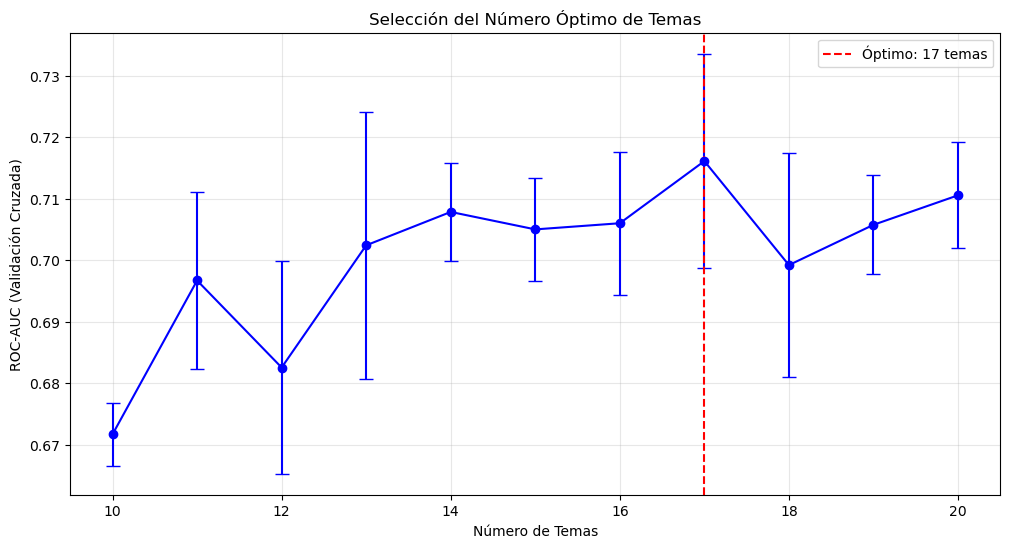


 Paso #7: Entrenamiento del modelo final
----------------------------------------
Entrenando LDA con 17 temas...
 Modelo entrenado exitosamente!

 Paso #8: Evaluación final (CV k=10)
----------------------------------------
 Evaluando fold 1/10...
 Evaluando fold 2/10...
 Evaluando fold 3/10...
 Evaluando fold 4/10...
 Evaluando fold 5/10...
 Evaluando fold 6/10...
 Evaluando fold 7/10...
 Evaluando fold 8/10...
 Evaluando fold 9/10...
 Evaluando fold 10/10...

 RESULTADOS FINALES:
  ROC-AUC promedio: 0.7070 (±0.0097)
  Intervalo de confianza 95%: [0.6879, 0.7260]

 Visualización de curva ROC
----------------------------------------
 Generando predicciones para fold 1/5...
 Generando predicciones para fold 2/5...
 Generando predicciones para fold 3/5...
 Generando predicciones para fold 4/5...
 Generando predicciones para fold 5/5...


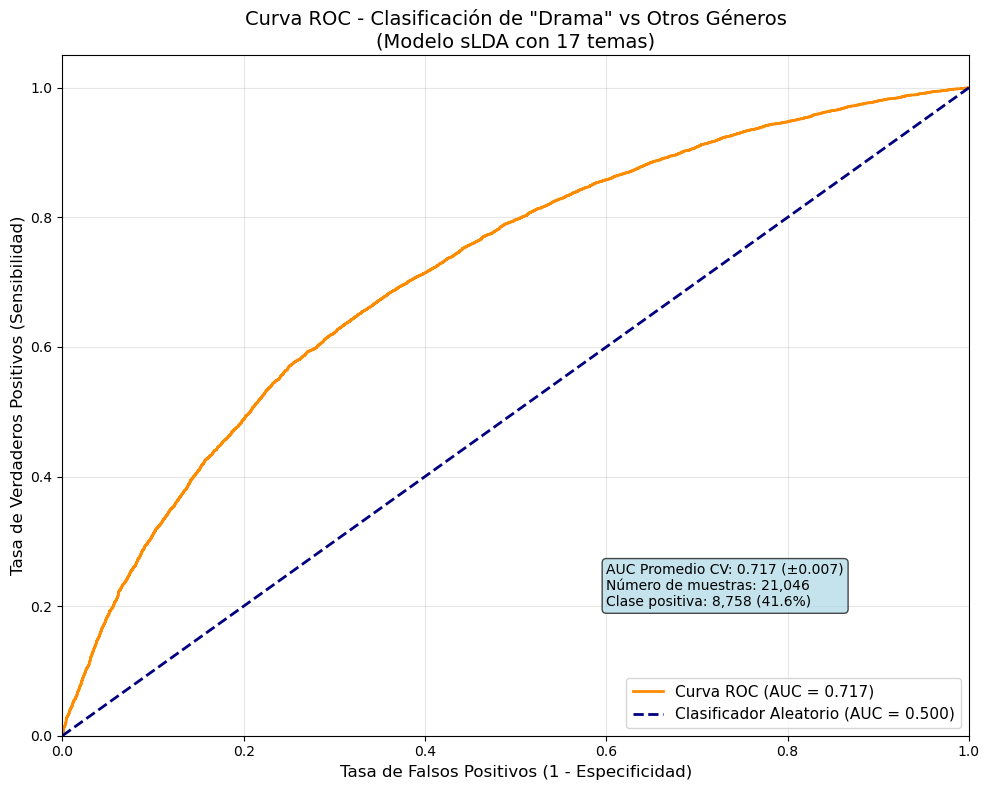


 Estadísticas de la curva ROC:
  AUC Global: 0.7167
  AUC Promedio CV: 0.7167 (±0.0069)
  Mejor fold: 0.7240
  Peor fold: 0.7058

 Thresold óptimo (Índice de Youden):
  Threshold: 0.422
  Sensibilidad: 0.650
  Especificidad: 0.674
  Índice J: 0.324

 Paso #9: Interpretación de temas
----------------------------------------
 Temas identificados (Top 10 palabras por tema):
  Tema 0: island(0.046), monster(0.028), scientist(0.025), lord(0.017), chinese(0.017), alien(0.016), experiment(0.015), treasure(0.013), politician(0.013), complex(0.013)
  Tema 1: town(0.049), small(0.041), village(0.035), baby(0.016), journey(0.012), mountain(0.012), deep(0.012), remote(0.011), north(0.011), reason(0.010)
  Tema 2: police(0.054), murder(0.053), gang(0.041), kill(0.036), killer(0.035), crime(0.029), revenge(0.027), detective(0.022), bank(0.022), murdered(0.019)
  Tema 3: race(0.025), bill(0.021), ghost(0.016), tom(0.016), rival(0.015), mary(0.014), gold(0.014), die(0.014), deadly(0.013), cat(0.013)


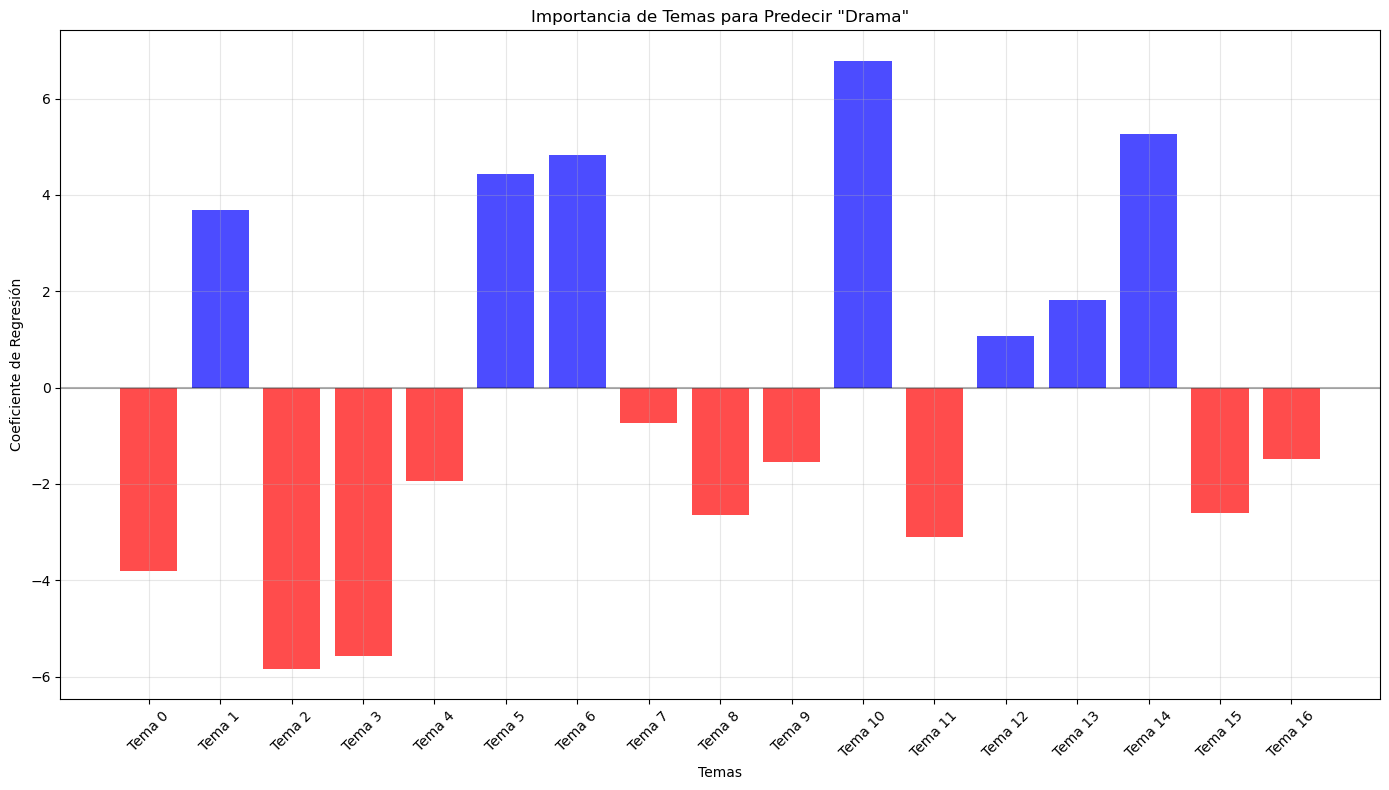


 Paso #10: Análisis de reseñas ficticias
----------------------------------------

--- Reseña 1 - Drama Familiar ---
 Texto: A touching story about a family struggling with loss and redemption. The father must reconnect with his estranged daughter after years of silence. Through tears and forgiveness, they learn to heal old wounds and find love again.

 Temas identificados:
  Tema 6 (0.365): life, one, love, young, woman
  Tema 5 (0.230): family, father, year, get, mother
  Tema 1 (0.087): town, small, village, baby, journey
  Tema 12 (0.082): film, story, documentary, movie, show

 Predicción:
  Probabilidad 'Drama': 0.531
  Probabilidad 'Otro género': 0.469
  Clasificación final: OKDrama

--- Reseña 2 - Acción Explosiva ---
 Texto: Fast-paced action thriller with explosions, car chases, and martial arts. The hero must stop terrorists from destroying the city using advanced weapons. Non-stop adrenaline with spectacular stunts and fight sequences.

 Temas identificados:
  Tema 6 (0.25

In [14]:
if __name__ == "__main__":
    # Ejecutar todo el pipeline para Drama
    results = run_complete_slda_pipeline(target_genre='Drama')
    
    if results:
        print(f"\n Todos los resultados están disponibles en la variable 'results'")
        print(f" Claves disponibles: {list(results.keys())}")
    else:
        print(" El pipeline no pudo completarse")